# Step 3, TreeModel_with_service_requests: Create a Random Forest Model to predict street tree falls USING service requests
** Note that throughout this and other jupyter notebooks, the following terminology is used:
- falls: refer to fallen branches (from the 311 service request dataset) since 2015
- service requests: refer to 311 service requests for damaged trees or overhanging branches (but NOT fallen branches) since 2015
- tree census: refers to the 2015 NYC Street Tree Census

Packages

In [61]:
# Import packages
%matplotlib inline
import category_encoders as ce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from inspect import signature
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

### Import model data from DataJoin

In [62]:
model_data_df = pd.read_csv('Data/Intermediate/model_data.csv',index_col='tree_id')

C:\Users\brian\.conda\envs\insight\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17,18,19,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Edit model data for modeling
Encode categorical data

In [63]:
# Encode categorical dataa

# First convert all Yes/No and True/False columns to 1/0
model_data_df.replace({'No': 0, 'Yes': 1},value=None,inplace=True)
model_data_df.replace({False: 0, True: 1},value=None,inplace=True)
model_data_df.replace(np.nan,0,inplace=True)

# Now convert all 2 option columns to 1/0
model_data_df.curb_loc.replace({'OnCurb':1, 'OffsetFromCurb':0},value=None,inplace=True)
model_data_df.sidewalk.replace({'Damage':1, 'NoDamage':0},value=None,inplace=True)
model_data_df.Fall.replace('Branch or Limb Has Fallen Down',1,inplace=True)

# Replace health, steward, and guards columns with numerical levels
model_data_df.health.replace({'Poor':0,'Fair':1,'Good':2},value=None,inplace=True)
model_data_df.steward.replace({'None':0,'1or2':1,'3or4':2,'4orMore':3},value=None,inplace=True)
model_data_df.guards.replace({'Harmful':0,'None':1,'Unsure':2,'Helpful':4},value=None,inplace=True)

# Target encode tree species descriptor data
# First split train and test data to prevent data leakage
df_train, df_test = train_test_split(model_data_df, random_state=1,test_size=0.25)

# Now, target encode training and test data based on training data encoding
target_dict = df_train.groupby('spc_common')['Fall'].mean()
df_train['spc_common'] = df_train['spc_common'].map(target_dict)
df_test['spc_common'] = df_test['spc_common'].map(target_dict)


C:\Users\brian\.conda\envs\insight\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\brian\.conda\envs\insight\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Fit a Random Forest to the features with service requests
Note that parameters were set by gridesearch, gridsearch code was moved to the bottom of the notebook.  The threshold was checked using a precision-recall curve, the code for this was also moved to the bottom of the notebook.

In [34]:
# First set a feature dataframe (x) and a target (y)
x_train = df_train.drop(['zipcode','Fall','address'],axis=1)
y_train = df_train.Fall

# oversample tree branch falls to del with the imbalanced classes
# Oversample fallen branch data to deal with class imbalance and turn data back into a DataFrame
sm = SMOTE(random_state=1, ratio = 1)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)
x_resampled = pd.DataFrame(x_train_res, columns=x_train.columns)
y_resampled = pd.DataFrame(y_train_res)

In [65]:
# Fit a random forest model
forest = RandomForestClassifier(n_jobs=-1,max_features='auto',class_weight='balanced_subsample',criterion='entropy',random_state = 10, max_depth = 3, n_estimators = 700)
model = forest.fit(x_resampled, y_resampled)

C:\Users\brian\.conda\envs\insight\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


### Find feature importances of the model

Feature ranking:
1. feature heightroof (0.349907)
2. feature spc_common (0.181971)
3. feature tree_dbh (0.118999)
4. feature sidewalk (0.116066)
5. feature root_stone (0.074902)
6. feature health (0.046781)
7. feature steward (0.035659)
8. feature curb_loc (0.021872)
9. feature trnk_other (0.019380)
10. feature root_other (0.010186)
11. feature Branch Cracked and Will Fall (0.010050)
12. feature guards (0.008659)
13. feature Hitting Building (0.002381)
14. feature trnk_wire (0.001547)
15. feature Dead Branches in Tree (0.000588)
16. feature Blocking Street (0.000558)
17. feature impervious_pct (0.000300)
18. feature Hitting Power/Phone Lines (0.000185)
19. feature root_grate (0.000007)
20. feature trnk_light (0.000001)
21. feature Tree Leaning/Uprooted (0.000000)
22. feature Tree Alive - in Poor Condition (0.000000)


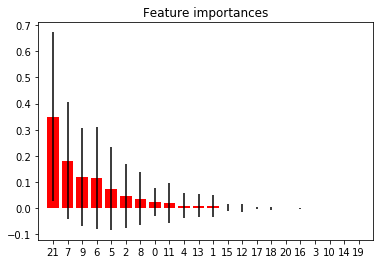

In [66]:
# Check feature importance random forest model
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, x_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

### Check model metrics
Recall is most important to ensure dangerous trees are mantained, we don't want to miss tree branches that will fall!

In [67]:
# Generate target predictions using the random forest model with the specified threshold (0.5 now)
x_test = df_test.drop(['zipcode','Fall','address'],axis=1)
y_test = df_test.Fall
y_pred = (forest.predict_proba(x_test)[:,1] >= 0.5).astype(bool)

In [68]:
# Check accuracy of model on test data
accuracy_score(y_test,y_pred)

0.7671693155526619

In [69]:
# Check ROC-AUC for model on test data
roc_auc_score(y_test,y_pred)

0.7336901180479272

In [70]:
# Check confusion matrix for model on test data
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted No Fall', 'Predicted Fall'],
    index=['True No Fall', 'True Fall']
)

,Predicted No Fall,Predicted Fall
True No Fall,129129,38826
True Fall,1226,2841


In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.77      0.87    167955
           1       0.07      0.70      0.12      4067

    accuracy                           0.77    172022
   macro avg       0.53      0.73      0.49    172022
weighted avg       0.97      0.77      0.85    172022



### Generate tree branch fall probabilities from the service request model
Then save these in an output file

In [54]:
# Calculate Fall probabilities of train and test trees from the no service request model
prob_train = forest.predict_proba(x_train)
prob_test = forest.predict_proba(x_test)

In [55]:
# combine the fall probabilities for the train and test trees, then append to other data to add fall probabilities to the tree census data
df_train['fallprob'] = prob_train[:,1]
df_test['fallprob'] = prob_test[:,1]
tree_branch_fall_prob_df = df_train.append(df_test)

C:\Users\brian\.conda\envs\insight\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\brian\.conda\envs\insight\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
# drop branch fall data from the tree census data with branch fall probabilities
tree_branch_fall_prob_df.drop('Fall',axis=1,inplace=True)

In [57]:
# Export data
tree_branch_fall_prob_df.to_csv('Data/FinalOutputs/ServiceRequestModelOutput.csv')

### Model tuning code
Code from model tuning was moved down here, it doesn't need to be re-run for modeling, and would take some time to run

Gridsearch:

In [64]:
#Try gridsearch to train model on 20% of the data (i.e. 25% of training data) so it doesn't take too long

# First split the training data to a smaller subset for grid search (to run faster)
grid_df, grid_df_valid = train_test_split(df_train, random_state=1,test_size=0.8)

# Set up feature (x) and target (y) data
grid_x = grid_df.drop(['zipcode','Fall','address'],axis=1)
grid_y = grid_df.Fall

# now correct the class imbalance by oversampling the tree branch fall data for the training data 
# Oversample fallen branch data to deal with class imbalance and turn data back into a DataFrame
sm = SMOTE(random_state=1, ratio = 1)

# Random forest model for grid search
grid_forest = imbPipeline([
    ('oversample', SMOTE(random_state=1,ratio=1)),
    ('rf', RandomForestClassifier(random_state = 1))])


# Grid search parameters
n_estimators = [500, 600, 700, 800]
max_depth = [3,4,5,6,7]
max_features = ['auto']
class_weight = ['balanced', 'balanced_subsample']
criterion = ['gini', 'entropy']
hyperF = dict(rf__criterion=criterion,rf__n_estimators = n_estimators, rf__max_depth = max_depth, rf__class_weight=class_weight,rf__max_features=max_features)


# Run grid search
gridF = GridSearchCV(grid_forest, hyperF, scoring = ['recall','f1'], n_jobs = -1,refit='recall')
gridF.fit(grid_x, grid_y)

# Check grid search results
#gridF.cv_results_['mean_test_score']



C:\Users\brian\.conda\envs\insight\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('oversample',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=1, ratio=1,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('rf',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion=...
                                                               verbose=0,
                                    

In [208]:
# See optimal gridsearch parameters
gridF.best_params_

{'rf__class_weight': 'balanced_subsample',
 'rf__criterion': 'entropy',
 'rf__max_depth': 3,
 'rf__max_features': 'auto',
 'rf__n_estimators': 700}

In [209]:
gridF.cv_results_

{'mean_fit_time': array([ 58.93318931, 108.61739834, 146.96148713,  65.30525891,
        112.90735229, 151.13801289,  56.7858115 , 100.92091831,
        143.42877801,  93.87027375, 132.35227092, 216.36920921,
         93.98057946, 138.01748713, 212.52720253,  85.43720762,
        142.59375612, 194.90593155, 130.38683844, 216.26458462,
        301.50480143, 130.02803961, 219.86586142, 305.63255072,
        130.19425011, 216.67676155, 300.24378824, 178.89882541,
        299.89621496, 417.43487032, 181.31071591, 294.74483816,
        412.86792302, 176.40578357, 304.6169072 , 416.17753792,
         69.94548639, 111.3221275 , 153.85610811,  67.82424625,
        112.89355596, 137.39875118,  62.99606442,  76.47392988,
         99.91437467,  64.30166459, 115.23238595, 165.52196797,
         72.94721142, 119.00315849, 164.62820133,  69.93191703,
        115.45139368, 158.56937726, 105.94549823, 175.54101467,
        245.77169585, 105.43259986, 175.18131566, 246.13993772,
        105.91845886, 1

In [210]:
# Predict validation data
grid_x_valid = grid_df_valid.drop(['zipcode','Fall','address'],axis=1)
grid_y_valid = grid_df_valid.Fall
grid_y_pred = gridF.predict(grid_x_valid)

# check grid search result roc-auc and confusion matrix
roc_auc_score(grid_y_valid,grid_y_pred)

pd.DataFrame(confusion_matrix(grid_y_valid,grid_y_pred),
    columns=['Predicted No Fall', 'Predicted Fall'],
    index=['True No Fall', 'True Fall'])

,Predicted No Fall,Predicted Fall
True No Fall,340141,89775
True Fall,3683,6776


In [211]:
accuracy_score(grid_y_valid,grid_y_pred)

0.7877763269940392

In [212]:
print(classification_report(grid_y_valid,grid_y_pred))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88    429916
           1       0.07      0.65      0.13     10459

    accuracy                           0.79    440375
   macro avg       0.53      0.72      0.50    440375
weighted avg       0.97      0.79      0.86    440375



Text(0.5, 1.0, '2-class Precision-Recall curve')

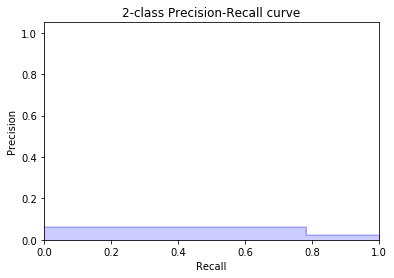

In [16]:
# Check the random forest precision recall curve to look at thresholds

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_train, forest.predict(x_train))

# Plot
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')

### EDA 
Code used to create some of the EDA figures

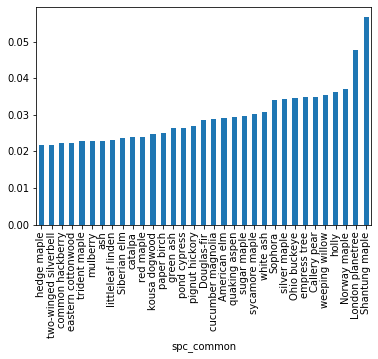

In [16]:
# Look at tree species with most falls
target_dict.sort_values()[100:133].plot.bar()

## Try other models

In [17]:
# Fit a logistic regression model
from sklearn.linear_model import LogisticRegression
lm_model = LogisticRegression(random_state=1,class_weight='balanced').fit(x_resampled, y_resampled)

C:\Users\brian\.conda\envs\insight\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brian\.conda\envs\insight\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
# check how the model performed
y_pred_lm = (lm_model.predict_proba(x_test)[:,1] >= 0.5).astype(bool)
print(classification_report(y_test,y_pred_lm))

              precision    recall  f1-score   support

           0       0.99      0.71      0.82    134334
           1       0.05      0.69      0.10      3283

    accuracy                           0.70    137617
   macro avg       0.52      0.70      0.46    137617
weighted avg       0.97      0.70      0.81    137617



In [19]:
roc_auc_score(y_test,y_pred_lm)

0.6981444919902933

In [25]:
# Try out naive bayes
from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()
gnb_model.fit(x_resampled,np.ravel(y_resampled))

GaussianNB(priors=None, var_smoothing=1e-09)

In [26]:
# check how the model performed
y_pred_gnb = (gnb_model.predict_proba(x_test)[:,1] >= 0.5).astype(bool)
print(classification_report(y_test,y_pred_gnb))

              precision    recall  f1-score   support

           0       0.98      0.26      0.41    134334
           1       0.03      0.80      0.05      3283

    accuracy                           0.27    137617
   macro avg       0.50      0.53      0.23    137617
weighted avg       0.96      0.27      0.40    137617



In [27]:
roc_auc_score(y_test,y_pred_gnb)

0.5273013408720281